## 1. Import Libraries

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import json
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 2. Load Data

In [87]:
df = pd.read_csv('azkaljayalas_dataset.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
df.head()

Dataset shape: (600, 20)

Columns: ['order_id', 'tanggal', 'tahun', 'pelanggan', 'lokasi', 'produk', 'jenis_material', 'profile_size', 'ketebalan_material', 'ukuran', 'jumlah_unit', 'jumlah_lubang', 'metode_hitung', 'harga_per_m2', 'harga_per_m', 'harga_per_lubang', 'upah_tenaga_ahli', 'finishing', 'kerumitan_desain', 'harga_final']


,order_id,tanggal,tahun,pelanggan,lokasi,produk,jenis_material,profile_size,ketebalan_material,ukuran,jumlah_unit,jumlah_lubang,metode_hitung,harga_per_m2,harga_per_m,harga_per_lubang,upah_tenaga_ahli,finishing,kerumitan_desain,harga_final
0,ORD-00001,3/29/2020,2020,Sukirman Wicaksono,Suradadi,Pintu Handerson,Hollow,4x4,0.8,4.73,1,0,PER-M2,800000,0,0,473000,Cat Biasa,Sederhana,3850000
1,ORD-00002,7/24/2024,2024,Bu Marni Sulastri,Balapulang,Railing,Hollow,4x4,0.8,2.70,3,0,PER-M,0,500000,0,810000,Cat Biasa,Kompleks,4250000
2,ORD-00003,3/19/2021,2021,Pak Darsono Hidayat,Margasari,Pagar,Hollow Stainless,4x8,1.2,12.80,1,0,PER-M2,1200000,0,0,1920000,Tanpa Cat,Sederhana,15350000
3,ORD-00004,8/22/2023,2023,Lilis Mariyam,Slawi,Pintu Gerbang,Hollow Stainless,4x4,0.8,6.00,1,0,PER-M2,1300000,0,0,900000,Tanpa Cat,Kompleks,7950000
4,ORD-00005,12/10/2021,2021,Dimas Ramadhan,Tegal,Pintu Handerson,Hollow,4x8,1.2,2.70,2,0,PER-M2,1000000,0,0,540000,Cat Biasa,Menengah,5550000


## 3. Data Quality Check

In [88]:
print("Missing values:")
missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "None")

print(f"\nDuplicate rows: {df.duplicated().sum()}")

print("\nBasic statistics:")
df.describe()

Missing values:
None

Duplicate rows: 0

Basic statistics:


,tahun,ketebalan_material,ukuran,jumlah_unit,jumlah_lubang,harga_per_m2,harga_per_m,harga_per_lubang,upah_tenaga_ahli,harga_final
count,600.000000,600.000000,600.000000,600.000000,600.000000,6.000000e+02,6.000000e+02,600.000000,6.000000e+02,6.000000e+02
mean,2022.078333,1.011000,8.908000,1.373333,2.413333,5.978333e+05,1.702000e+05,114250.000000,1.941509e+06,1.161650e+07
std,1.947267,0.172032,7.315577,0.729046,5.688564,5.306518e+05,3.795894e+05,257364.524227,1.384982e+06,7.360056e+06
min,2019.000000,0.800000,0.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,2.280000e+05,1.200000e+06
25%,2020.000000,0.800000,3.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,9.545000e+05,6.150000e+06
50%,2022.000000,1.000000,7.400000,1.000000,0.000000,6.500000e+05,0.000000e+00,0.000000,1.600000e+06,1.000000e+07
75%,2024.000000,1.200000,13.677500,2.000000,0.000000,9.625000e+05,0.000000e+00,0.000000,2.550000e+06,1.492500e+07
max,2025.000000,1.200000,30.000000,7.000000,28.000000,1.850000e+06,1.350000e+06,900000.000000,8.876000e+06,4.680000e+07


## 3.2. Outlier Detection

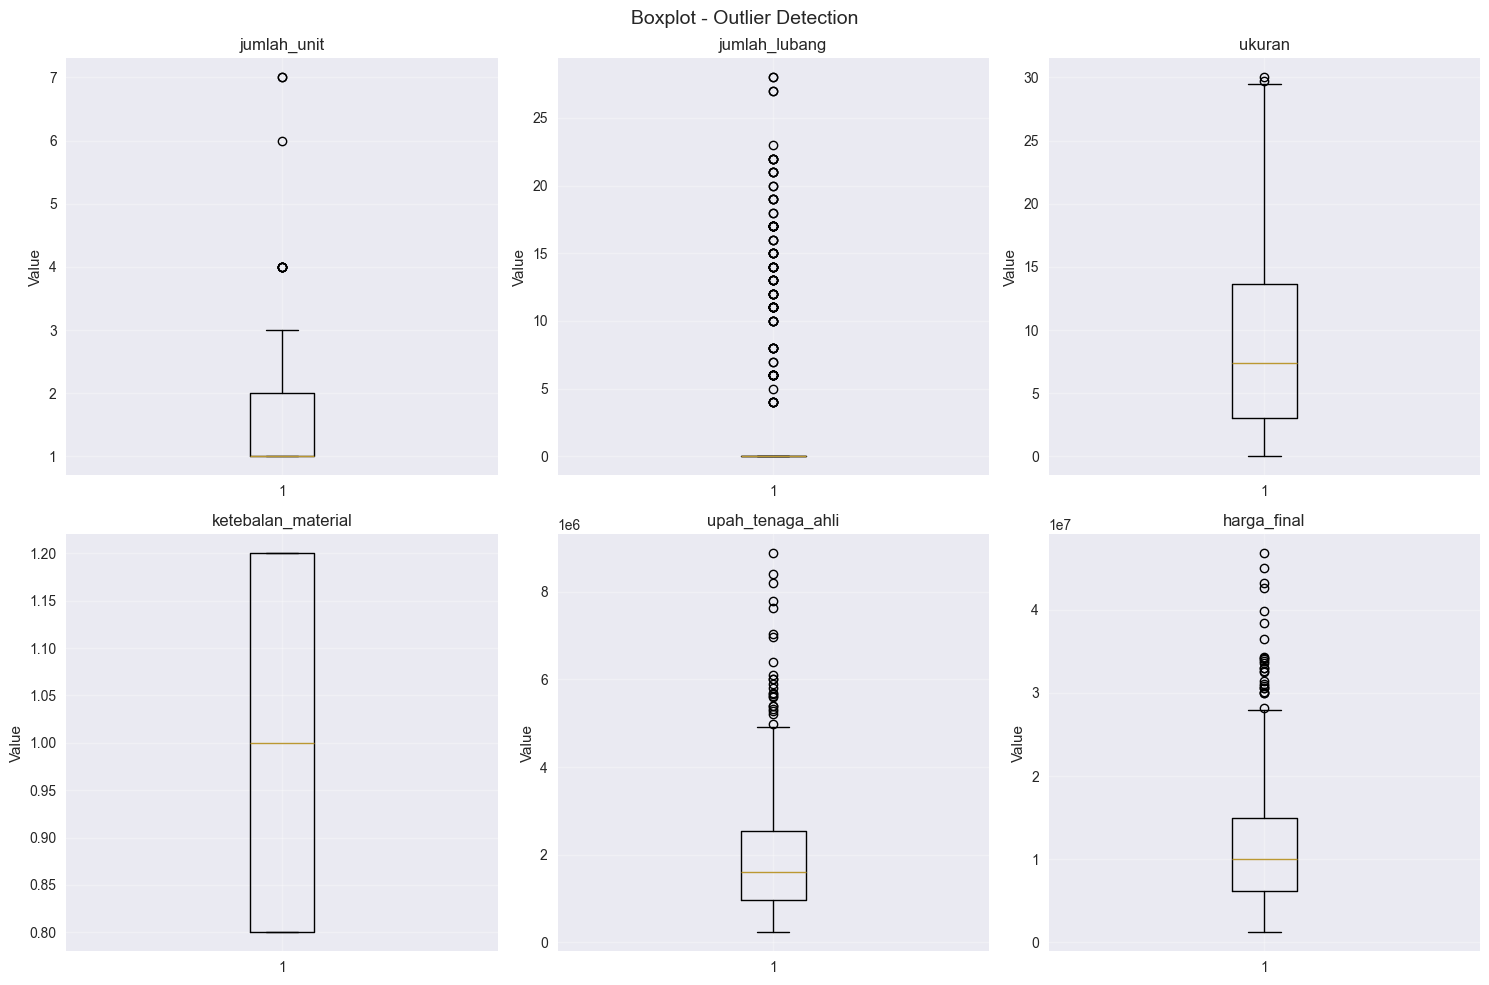

In [89]:
numerical_cols = ['jumlah_unit', 'jumlah_lubang', 'ukuran', 'ketebalan_material', 'upah_tenaga_ahli', 'harga_final']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Boxplot - Outlier Detection', fontsize=14)

for idx, col in enumerate(numerical_cols):
    row = idx // 3
    col_idx = idx % 3
    axes[row, col_idx].boxplot(df[col].dropna(), vert=True)
    axes[row, col_idx].set_title(col)
    axes[row, col_idx].set_ylabel('Value')
    axes[row, col_idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [90]:
numerical_cols = ['jumlah_unit', 'jumlah_lubang', 'ukuran', 'ketebalan_material', 'upah_tenaga_ahli', 'harga_final']

print("Outlier Detection (IQR Method):\n")
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(f"{col}:")
    print(f"  Outliers: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")
    print(f"  Range: [{lower:,.0f}, {upper:,.0f}]\n")

total_outliers = df[numerical_cols].apply(
    lambda x: (x < (x.quantile(0.25) - 1.5 * (x.quantile(0.75) - x.quantile(0.25)))) | 
              (x > (x.quantile(0.75) + 1.5 * (x.quantile(0.75) - x.quantile(0.25))))
).any(axis=1).sum()

print(f"Total rows with outliers: {total_outliers} ({total_outliers/len(df)*100:.2f}%)")

Outlier Detection (IQR Method):

jumlah_unit:
  Outliers: 10 (1.67%)
  Range: [-0, 4]

jumlah_lubang:
  Outliers: 109 (18.17%)
  Range: [0, 0]

ukuran:
  Outliers: 2 (0.33%)
  Range: [-13, 30]

ketebalan_material:
  Outliers: 0 (0.00%)
  Range: [0, 2]

upah_tenaga_ahli:
  Outliers: 23 (3.83%)
  Range: [-1,438,750, 4,943,250]

harga_final:
  Outliers: 25 (4.17%)
  Range: [-7,012,500, 28,087,500]

Total rows with outliers: 150 (25.00%)


## 3.1. Outlier Handling

## 4. Exploratory Data Analysis

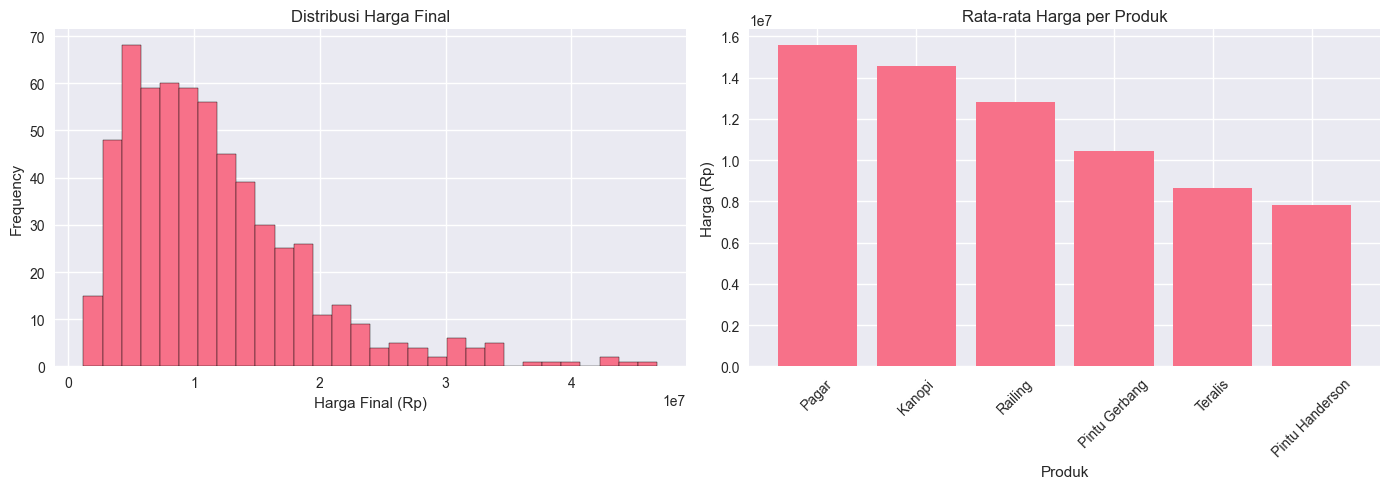

Mean: Rp 11,616,500
Median: Rp 10,000,000
Range: Rp 1,200,000 - Rp 46,800,000


In [91]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['harga_final'], bins=30, edgecolor='black')
axes[0].set_title('Distribusi Harga Final')
axes[0].set_xlabel('Harga Final (Rp)')
axes[0].set_ylabel('Frequency')

avg_by_product = df.groupby('produk')['harga_final'].mean().sort_values(ascending=False)
axes[1].bar(avg_by_product.index, avg_by_product.values)
axes[1].set_title('Rata-rata Harga per Produk')
axes[1].set_xlabel('Produk')
axes[1].set_ylabel('Harga (Rp)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"Mean: Rp {df['harga_final'].mean():,.0f}")
print(f"Median: Rp {df['harga_final'].median():,.0f}")
print(f"Range: Rp {df['harga_final'].min():,.0f} - Rp {df['harga_final'].max():,.0f}")

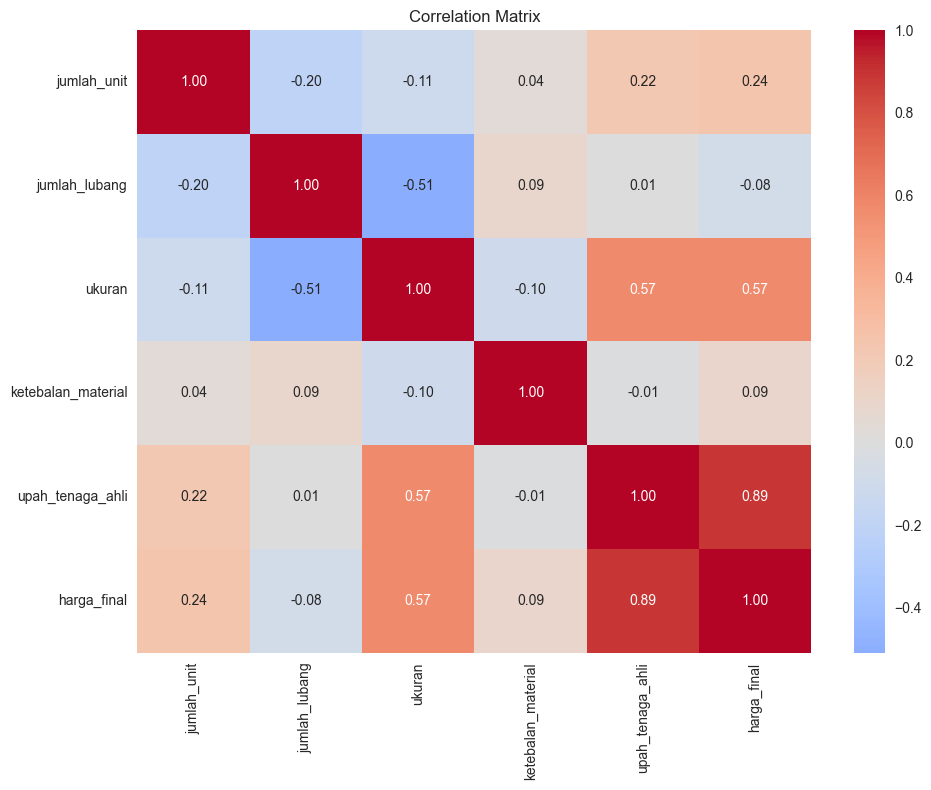

In [92]:
numerical_cols = ['jumlah_unit', 'jumlah_lubang', 'ukuran', 'ketebalan_material', 'upah_tenaga_ahli', 'harga_final']
corr_matrix = df[numerical_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

## 5. Feature Engineering

In [93]:
material_base_price_map = {
    ('Pagar', 2019, 'Hollow'): 500000, ('Pagar', 2020, 'Hollow'): 500000, ('Pagar', 2021, 'Hollow'): 500000,
    ('Pagar', 2022, 'Hollow'): 530000, ('Pagar', 2023, 'Hollow'): 550000, ('Pagar', 2024, 'Hollow'): 550000,
    ('Pagar', 2025, 'Hollow'): 600000,
    ('Pagar', 2019, 'Hollow Stainless'): 1000000, ('Pagar', 2020, 'Hollow Stainless'): 1050000, ('Pagar', 2021, 'Hollow Stainless'): 1100000,
    ('Pagar', 2022, 'Hollow Stainless'): 1130000, ('Pagar', 2023, 'Hollow Stainless'): 1150000, ('Pagar', 2024, 'Hollow Stainless'): 1180000,
    ('Pagar', 2025, 'Hollow Stainless'): 1200000,
    ('Pagar', 2019, 'Pipa Stainless'): 850000, ('Pagar', 2020, 'Pipa Stainless'): 880000, ('Pagar', 2021, 'Pipa Stainless'): 900000,
    ('Pagar', 2022, 'Pipa Stainless'): 920000, ('Pagar', 2023, 'Pipa Stainless'): 940000, ('Pagar', 2024, 'Pipa Stainless'): 960000,
    ('Pagar', 2025, 'Pipa Stainless'): 1000000,
    
    ('Kanopi', 2019, 'Hollow'): 350000, ('Kanopi', 2020, 'Hollow'): 350000, ('Kanopi', 2021, 'Hollow'): 350000,
    ('Kanopi', 2022, 'Hollow'): 350000, ('Kanopi', 2023, 'Hollow'): 420000, ('Kanopi', 2024, 'Hollow'): 450000,
    ('Kanopi', 2025, 'Hollow'): 450000,
    ('Kanopi', 2019, 'Hollow Stainless'): 650000, ('Kanopi', 2020, 'Hollow Stainless'): 700000, ('Kanopi', 2021, 'Hollow Stainless'): 750000,
    ('Kanopi', 2022, 'Hollow Stainless'): 780000, ('Kanopi', 2023, 'Hollow Stainless'): 800000, ('Kanopi', 2024, 'Hollow Stainless'): 800000,
    ('Kanopi', 2025, 'Hollow Stainless'): 800000,
    ('Kanopi', 2019, 'Pipa Stainless'): 600000, ('Kanopi', 2020, 'Pipa Stainless'): 630000, ('Kanopi', 2021, 'Pipa Stainless'): 660000,
    ('Kanopi', 2022, 'Pipa Stainless'): 680000, ('Kanopi', 2023, 'Pipa Stainless'): 700000, ('Kanopi', 2024, 'Pipa Stainless'): 700000,
    ('Kanopi', 2025, 'Pipa Stainless'): 700000,
    
    ('Pintu Gerbang', 2019, 'Hollow'): 550000, ('Pintu Gerbang', 2020, 'Hollow'): 600000, ('Pintu Gerbang', 2021, 'Hollow'): 600000,
    ('Pintu Gerbang', 2022, 'Hollow'): 650000, ('Pintu Gerbang', 2023, 'Hollow'): 700000, ('Pintu Gerbang', 2024, 'Hollow'): 750000,
    ('Pintu Gerbang', 2025, 'Hollow'): 750000,
    ('Pintu Gerbang', 2019, 'Hollow Stainless'): 1100000, ('Pintu Gerbang', 2020, 'Hollow Stainless'): 1150000, ('Pintu Gerbang', 2021, 'Hollow Stainless'): 1200000,
    ('Pintu Gerbang', 2022, 'Hollow Stainless'): 1250000, ('Pintu Gerbang', 2023, 'Hollow Stainless'): 1300000, ('Pintu Gerbang', 2024, 'Hollow Stainless'): 1420000,
    ('Pintu Gerbang', 2025, 'Hollow Stainless'): 1500000,
    ('Pintu Gerbang', 2019, 'Pipa Stainless'): 950000, ('Pintu Gerbang', 2020, 'Pipa Stainless'): 1000000, ('Pintu Gerbang', 2021, 'Pipa Stainless'): 1050000,
    ('Pintu Gerbang', 2022, 'Pipa Stainless'): 1100000, ('Pintu Gerbang', 2023, 'Pipa Stainless'): 1150000, ('Pintu Gerbang', 2024, 'Pipa Stainless'): 1180000,
    ('Pintu Gerbang', 2025, 'Pipa Stainless'): 1200000,
    
    ('Teralis', 2019, 'Hollow'): 300000, ('Teralis', 2020, 'Hollow'): 300000, ('Teralis', 2021, 'Hollow'): 300000,
    ('Teralis', 2022, 'Hollow'): 300000, ('Teralis', 2023, 'Hollow'): 350000, ('Teralis', 2024, 'Hollow'): 350000,
    ('Teralis', 2025, 'Hollow'): 350000,
    ('Teralis', 2019, 'Hollow Stainless'): 650000, ('Teralis', 2020, 'Hollow Stainless'): 700000, ('Teralis', 2021, 'Hollow Stainless'): 750000,
    ('Teralis', 2022, 'Hollow Stainless'): 780000, ('Teralis', 2023, 'Hollow Stainless'): 800000, ('Teralis', 2024, 'Hollow Stainless'): 800000,
    ('Teralis', 2025, 'Hollow Stainless'): 800000,
    ('Teralis', 2019, 'Pipa Stainless'): 600000, ('Teralis', 2020, 'Pipa Stainless'): 620000, ('Teralis', 2021, 'Pipa Stainless'): 640000,
    ('Teralis', 2022, 'Pipa Stainless'): 660000, ('Teralis', 2023, 'Pipa Stainless'): 680000, ('Teralis', 2024, 'Pipa Stainless'): 700000,
    ('Teralis', 2025, 'Pipa Stainless'): 700000,
    
    ('Railing', 2019, 'Hollow'): 400000, ('Railing', 2020, 'Hollow'): 400000, ('Railing', 2021, 'Hollow'): 450000,
    ('Railing', 2022, 'Hollow'): 450000, ('Railing', 2023, 'Hollow'): 500000, ('Railing', 2024, 'Hollow'): 500000,
    ('Railing', 2025, 'Hollow'): 500000,
    ('Railing', 2019, 'Hollow Stainless'): 1000000, ('Railing', 2020, 'Hollow Stainless'): 1050000, ('Railing', 2021, 'Hollow Stainless'): 1100000,
    ('Railing', 2022, 'Hollow Stainless'): 1120000, ('Railing', 2023, 'Hollow Stainless'): 1150000, ('Railing', 2024, 'Hollow Stainless'): 1180000,
    ('Railing', 2025, 'Hollow Stainless'): 1200000,
    ('Railing', 2019, 'Pipa Stainless'): 850000, ('Railing', 2020, 'Pipa Stainless'): 880000, ('Railing', 2021, 'Pipa Stainless'): 900000,
    ('Railing', 2022, 'Pipa Stainless'): 920000, ('Railing', 2023, 'Pipa Stainless'): 950000, ('Railing', 2024, 'Pipa Stainless'): 1000000,
    ('Railing', 2025, 'Pipa Stainless'): 1000000,
    
    ('Pintu Handerson', 2019, 'Hollow'): 750000, ('Pintu Handerson', 2020, 'Hollow'): 800000, ('Pintu Handerson', 2021, 'Hollow'): 800000,
    ('Pintu Handerson', 2022, 'Hollow'): 800000, ('Pintu Handerson', 2023, 'Hollow'): 850000, ('Pintu Handerson', 2024, 'Hollow'): 900000,
    ('Pintu Handerson', 2025, 'Hollow'): 900000,
    ('Pintu Handerson', 2019, 'Hollow Stainless'): 1300000, ('Pintu Handerson', 2020, 'Hollow Stainless'): 1350000, ('Pintu Handerson', 2021, 'Hollow Stainless'): 1420000,
    ('Pintu Handerson', 2022, 'Hollow Stainless'): 1460000, ('Pintu Handerson', 2023, 'Hollow Stainless'): 1500000, ('Pintu Handerson', 2024, 'Hollow Stainless'): 1600000,
    ('Pintu Handerson', 2025, 'Hollow Stainless'): 1700000,
    ('Pintu Handerson', 2019, 'Pipa Stainless'): 1200000, ('Pintu Handerson', 2020, 'Pipa Stainless'): 1250000, ('Pintu Handerson', 2021, 'Pipa Stainless'): 1300000,
    ('Pintu Handerson', 2022, 'Pipa Stainless'): 1350000, ('Pintu Handerson', 2023, 'Pipa Stainless'): 1400000, ('Pintu Handerson', 2024, 'Pipa Stainless'): 1450000,
    ('Pintu Handerson', 2025, 'Pipa Stainless'): 1500000,
}

def get_material_price(row):
    tahun = row.get('tahun', 2025)
    key = (row['produk'], int(tahun), row['jenis_material'])
    return material_base_price_map.get(key, 500000)

df['material_base_price'] = df.apply(get_material_price, axis=1)
df['thickness_premium'] = df['ketebalan_material'].map({0.8: 0, 1.0: 50000, 1.2: 100000}).fillna(0)
df['profile_premium'] = df['profile_size'].map({'4x4': 0, '4x6': 50000, '4x8': 100000}).fillna(0)
df['total_area'] = df['jumlah_unit'] * df['ukuran']
df['total_lubang'] = df['jumlah_unit'] * df['jumlah_lubang']

df.loc[df['metode_hitung'].str.upper() == 'PER-LUBANG', 'total_area'] = 0
df.loc[df['metode_hitung'].str.upper() == 'PER-M2', 'total_lubang'] = 0

print("Feature engineering completed")
print(f"New features: material_base_price, thickness_premium, profile_premium, total_area, total_lubang")

Feature engineering completed
New features: material_base_price, thickness_premium, profile_premium, total_area, total_lubang


## 6. Model Training

In [94]:
feature_columns = [
    'produk', 'jenis_material', 'finishing', 'kerumitan_desain', 'metode_hitung', 'profile_size',
    'jumlah_unit', 'jumlah_lubang', 'ukuran', 'ketebalan_material',
    'material_base_price', 'thickness_premium', 'profile_premium',
    'total_area', 'total_lubang'
]

X = df[feature_columns]
y = df['harga_final']

print(f"Features: {len(feature_columns)}")
print(f"Samples: {len(X)}")

Features: 15
Samples: 600


In [95]:
categorical_features = ['produk', 'jenis_material', 'finishing', 'metode_hitung', 'profile_size']
ordinal_features = ['kerumitan_desain']
numeric_features = ['jumlah_unit', 'jumlah_lubang', 'ukuran', 'ketebalan_material',
                   'material_base_price', 'thickness_premium', 'profile_premium',
                   'total_area', 'total_lubang']

numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='UNKNOWN')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='UNKNOWN')),
    ('ordinal', OrdinalEncoder(categories=[['UNKNOWN', 'Sederhana', 'Menengah', 'Kompleks']], 
                              handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),
    ('ord', ordinal_transformer, ordinal_features)
])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))
])

print("Pipeline created")

Pipeline created


In [96]:
# Split: 500 training samples, 100 testing samples
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=100,  # 100 samples untuk testing
    random_state=42
)

print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Testing set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"Total samples: {len(X)}")

Training set: 500 samples (83.3%)
Testing set: 100 samples (16.7%)
Total samples: 600


In [97]:
cv_results = cross_validate(
    model_pipeline, X_train, y_train, 
    cv=5, 
    scoring=['neg_mean_absolute_error', 'r2'],
    return_train_score=True,
    n_jobs=-1
)

cv_train_r2 = cv_results['train_r2'].mean()
cv_val_r2 = cv_results['test_r2'].mean()
cv_train_mae = -cv_results['train_neg_mean_absolute_error'].mean()
cv_val_mae = -cv_results['test_neg_mean_absolute_error'].mean()

print("5-Fold Cross-Validation Results:")
print(f"Training R²:   {cv_train_r2:.4f}")
print(f"Validation R²: {cv_val_r2:.4f}")
print(f"Training MAE:  Rp {cv_train_mae:,.0f}")
print(f"Validation MAE: Rp {cv_val_mae:,.0f}")
print(f"Overfitting Gap: {(cv_train_r2 - cv_val_r2)*100:.2f}%")

5-Fold Cross-Validation Results:
Training R²:   0.9938
Validation R²: 0.9554
Training MAE:  Rp 352,152
Validation MAE: Rp 934,512
Overfitting Gap: 3.84%


In [98]:
model_pipeline.fit(X_train, y_train)

y_train_pred = model_pipeline.predict(X_train)
y_test_pred = model_pipeline.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("Training Set:")
print(f"  R²:   {train_r2:.4f}")
print(f"  MAE:  Rp {train_mae:,.0f}")
print(f"  RMSE: Rp {train_rmse:,.0f}")

print("\nTest Set:")
print(f"  R²:   {test_r2:.4f}")
print(f"  MAE:  Rp {test_mae:,.0f}")
print(f"  RMSE: Rp {test_rmse:,.0f}")

print(f"\nOverfitting Gap: {(train_r2 - test_r2)*100:.2f}%")

Training Set:
  R²:   0.9951
  MAE:  Rp 315,922
  RMSE: Rp 500,352

Test Set:
  R²:   0.9724
  MAE:  Rp 896,915
  RMSE: Rp 1,387,795

Overfitting Gap: 2.26%


## 7. Model Evaluation

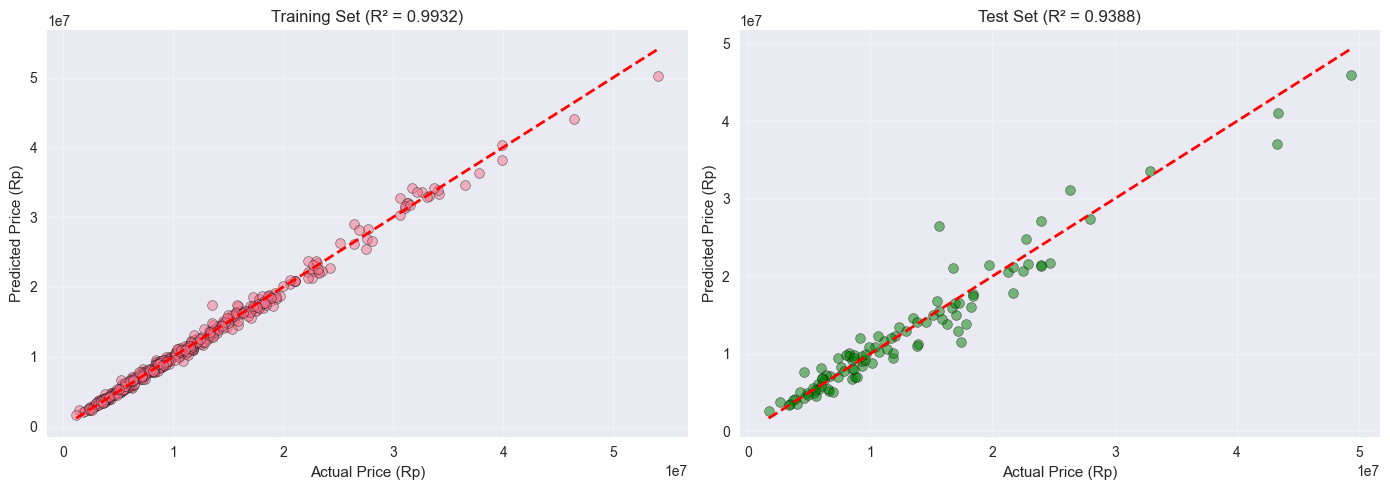

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(y_train, y_train_pred, alpha=0.5, edgecolors='black', linewidth=0.5)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Price (Rp)')
axes[0].set_ylabel('Predicted Price (Rp)')
axes[0].set_title(f'Training Set (R² = {train_r2:.4f})')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(y_test, y_test_pred, alpha=0.5, color='green', edgecolors='black', linewidth=0.5)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Price (Rp)')
axes[1].set_ylabel('Predicted Price (Rp)')
axes[1].set_title(f'Test Set (R² = {test_r2:.4f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

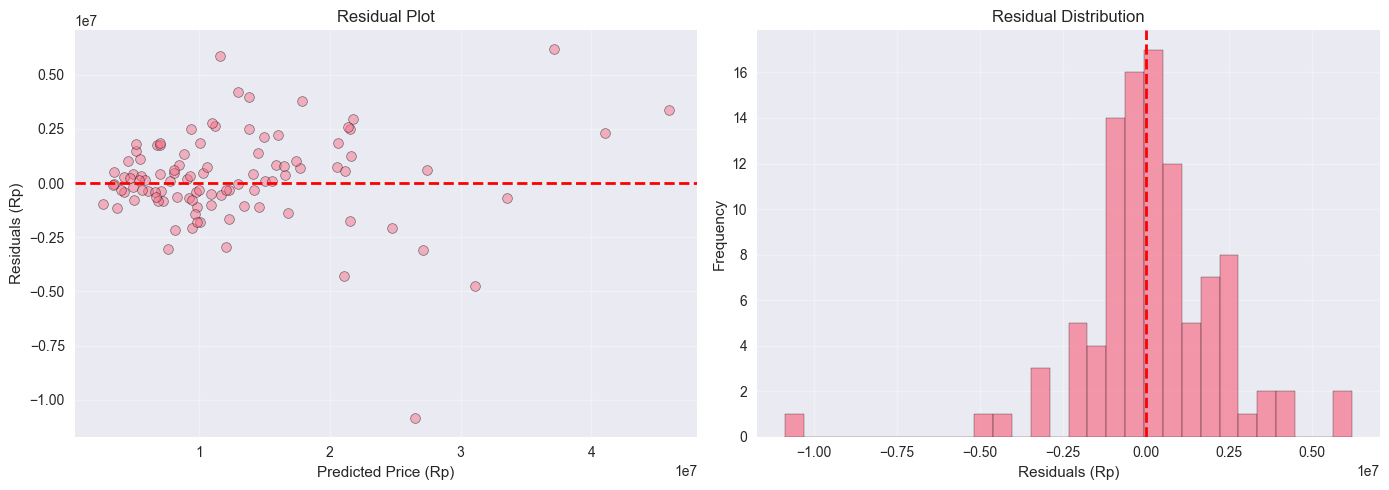

Mean Residual: Rp 205,125
Std Residual: Rp 2,137,266


In [ ]:
residuals = y_test - y_test_pred

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(y_test_pred, residuals, alpha=0.5, edgecolors='black', linewidth=0.5)
axes[0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0].set_xlabel('Predicted Price (Rp)')
axes[0].set_ylabel('Residuals (Rp)')
axes[0].set_title('Residual Plot')
axes[0].grid(True, alpha=0.3)

axes[1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Residuals (Rp)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Residual Distribution')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mean Residual: Rp {residuals.mean():,.0f}")
print(f"Std Residual: Rp {residuals.std():,.0f}")

## 8. Feature Importance

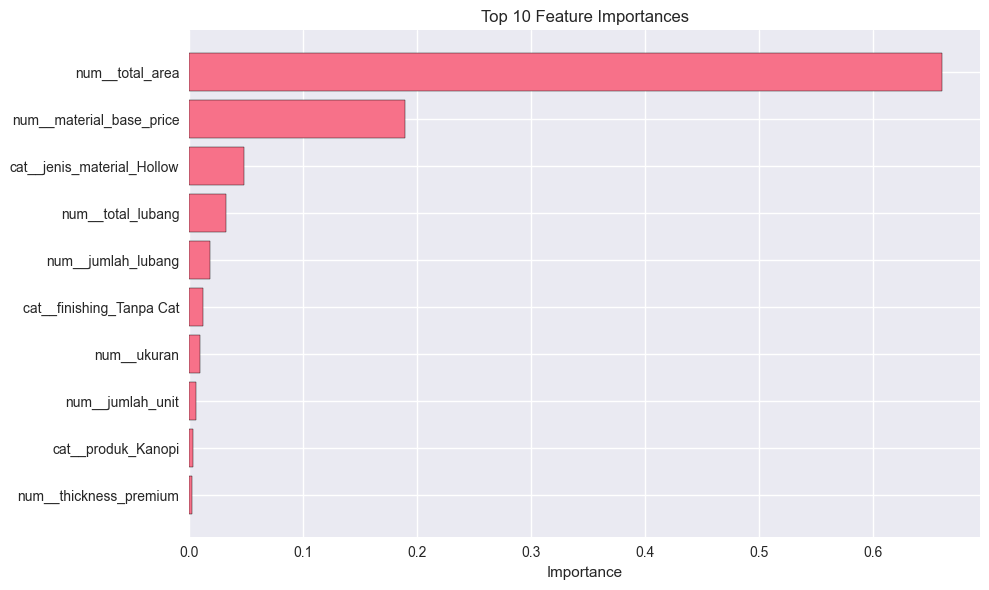

num__total_area: 0.6604
num__material_base_price: 0.1889
cat__jenis_material_Hollow: 0.0483
num__total_lubang: 0.0325
num__jumlah_lubang: 0.0185
cat__finishing_Tanpa Cat: 0.0123
num__ukuran: 0.0091
num__jumlah_unit: 0.0065
cat__produk_Kanopi: 0.0038
num__thickness_premium: 0.0025


In [ ]:
with open('feature_importances.json', 'r') as f:
    feature_importances = json.load(f)

top_features = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)[:10]
features, importances = zip(*top_features)

plt.figure(figsize=(10, 6))
plt.barh(range(len(features)), importances, edgecolor='black')
plt.yticks(range(len(features)), features)
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

for feature, importance in top_features:
    print(f"{feature}: {importance:.4f}")

## 9. Eksperimen: Perbandingan Model

In [102]:
features_without_upah = feature_columns
features_with_upah = features_without_upah + ['upah_tenaga_ahli']

X_without = df[features_without_upah]
X_with = df[features_with_upah]

X_train_no, X_test_no, y_train_no, y_test_no = train_test_split(X_without, y, test_size=0.2, random_state=42)
X_train_yes, X_test_yes, y_train_yes, y_test_yes = train_test_split(X_with, y, test_size=0.2, random_state=42)

numeric_with_upah = numeric_features + ['upah_tenaga_ahli']
preprocessor_with = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_with_upah),
    ('cat', categorical_transformer, categorical_features),
    ('ord', ordinal_transformer, ordinal_features)
])

model_no_upah = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))
])

model_with_upah = Pipeline(steps=[
    ('preprocessor', preprocessor_with),
    ('model', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))
])

cv_no = cross_validate(model_no_upah, X_train_no, y_train_no, cv=5, 
                       scoring=['r2', 'neg_mean_absolute_error'], return_train_score=True)
cv_yes = cross_validate(model_with_upah, X_train_yes, y_train_yes, cv=5, 
                        scoring=['r2', 'neg_mean_absolute_error'], return_train_score=True)

model_no_upah.fit(X_train_no, y_train_no)
model_with_upah.fit(X_train_yes, y_train_yes)

test_r2_no = r2_score(y_test_no, model_no_upah.predict(X_test_no))
test_r2_yes = r2_score(y_test_yes, model_with_upah.predict(X_test_yes))
test_mae_no = mean_absolute_error(y_test_no, model_no_upah.predict(X_test_no))
test_mae_yes = mean_absolute_error(y_test_yes, model_with_upah.predict(X_test_yes))

cv_train_r2_no = cv_no['train_r2'].mean()
cv_val_r2_no = cv_no['test_r2'].mean()
cv_train_r2_yes = cv_yes['train_r2'].mean()
cv_val_r2_yes = cv_yes['test_r2'].mean()

print("Model Tanpa Upah (15 fitur):")
print(f"  CV Train R²: {cv_train_r2_no:.4f}")
print(f"  CV Val R²:   {cv_val_r2_no:.4f}")
print(f"  Test R²:     {test_r2_no:.4f}")
print(f"  Test MAE:    Rp {test_mae_no:,.0f}")
print(f"  Gap (CV):    {(cv_train_r2_no - cv_val_r2_no)*100:.2f}%")

print("\nModel Dengan Upah (16 fitur):")
print(f"  CV Train R²: {cv_train_r2_yes:.4f}")
print(f"  CV Val R²:   {cv_val_r2_yes:.4f}")
print(f"  Test R²:     {test_r2_yes:.4f}")
print(f"  Test MAE:    Rp {test_mae_yes:,.0f}")
print(f"  Gap (CV):    {(cv_train_r2_yes - cv_val_r2_yes)*100:.2f}%")

Model Tanpa Upah (15 fitur):
  CV Train R²: 0.9937
  CV Val R²:   0.9594
  Test R²:     0.9690
  Test MAE:    Rp 935,304
  Gap (CV):    3.43%

Model Dengan Upah (16 fitur):
  CV Train R²: 0.9926
  CV Val R²:   0.9521
  Test R²:     0.9715
  Test MAE:    Rp 927,808
  Gap (CV):    4.05%


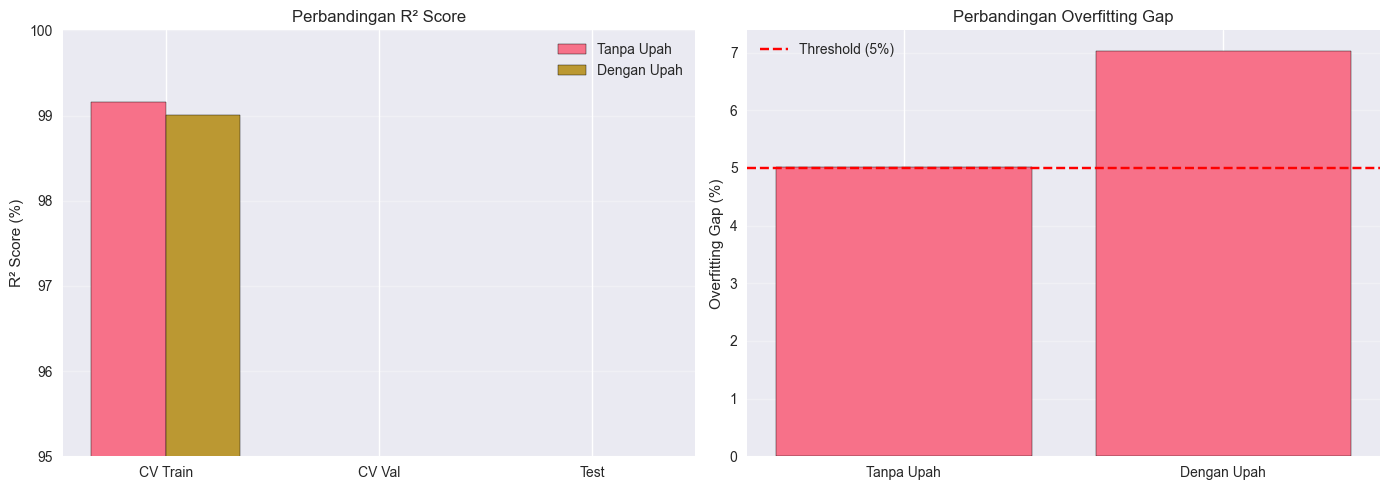

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

metrics = ['CV Train', 'CV Val', 'Test']
model1_r2 = [cv_train_r2_no*100, cv_val_r2_no*100, test_r2_no*100]
model2_r2 = [cv_train_r2_yes*100, cv_val_r2_yes*100, test_r2_yes*100]

x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, model1_r2, width, label='Tanpa Upah', edgecolor='black')
axes[0].bar(x + width/2, model2_r2, width, label='Dengan Upah', edgecolor='black')
axes[0].set_ylabel('R² Score (%)')
axes[0].set_title('Perbandingan R² Score')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([95, 100])

gap_no = (cv_train_r2_no - cv_val_r2_no) * 100
gap_yes = (cv_train_r2_yes - cv_val_r2_yes) * 100

axes[1].bar(['Tanpa Upah', 'Dengan Upah'], [gap_no, gap_yes], edgecolor='black')
axes[1].set_ylabel('Overfitting Gap (%)')
axes[1].set_title('Perbandingan Overfitting Gap')
axes[1].axhline(y=5, color='red', linestyle='--', label='Threshold (5%)')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()